## Algoritmo: Gradient Boosting Classifier (GBC)

En este ejemplo se utiliza el algoritmo de clasificación: **GBC** para predecir si existe sequía o no en una ciudad a partir del clima y la temperatura, los datos son:

| Variable       | Tipo             | Descripción                                            |
|----------------|------------------|--------------------------------------------------------|
| clima       | Cadena  | Es el clima actual de la ciudad (soleado, nublado, lluvioso)       |
| temperatura       | Cadena  | Temperatura actual de la ciudad (caliente, templado, frio)   |
| Sequía       | Cadena  | Describe la existencia de sequía para la ciudad  (si, no)         |

**Nota:** Los datos de este ejemplo ya tienen preprocesamiento.

### Paso 1: Importar las librerias

In [1]:
# Libreria para operaciones matemáticas o estadísticas
import numpy as np
# Libreria para el manejo de datos
import pandas as pd
# Librerias para gráficas
import matplotlib.pyplot as plt
import seaborn as sb
# Librería para transformar datos
from sklearn.preprocessing import LabelEncoder
# Libreria para el balanceo de los datos
from sklearn.utils import resample
# Libreria para separar el conjunto de datos en entrenamiento y pruebas
from sklearn.model_selection import train_test_split
# Libreria para Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
# Librerias para métricas del modelo
from sklearn.metrics import precision_score, recall_score, f1_score
# Libreria para calcular la media y la desviación estándar utilizadas en las características
from sklearn.preprocessing import StandardScaler
# Libreria para menejo de hiperparámetros
from sklearn.model_selection import GridSearchCV

### Paso 2: Cargar el archivo plano en un DataFrame

In [2]:
# Se cargan los datos del archivo plano: '1.6-clima.csv' a un DataFrame
df = pd.read_csv("data/1.6-clima.csv")

### Paso 3: Procesamiento de los datos

In [3]:
# Se muestran los primeros 10 registros del DataFrame
df.head(10)

,clima,temperatura,sequia
0,soleado,caliente,si
1,soleado,caliente,si
2,nublado,caliente,si
3,lluvioso,templado,si
4,lluvioso,frio,no
5,lluvioso,frio,no
6,nublado,frio,si
7,soleado,templado,no
8,soleado,frio,si
9,lluvioso,templado,si


In [4]:
# Se identifican los valores NaN del DataFrame
print("Columna       Cantidad NaN")
print(df.isnull().sum(axis = 0))

#df.dropna()


Columna       Cantidad NaN
clima          0
temperatura    0
sequia         0
dtype: int64


##### NOTA: Como no hay valores NaN en las columnas, no es necesario aplicar 'dropna()' para eliminarlos

In [5]:
# Se reemplazan los valores de tipo cadena a numéricos para generar la predicción
le = LabelEncoder()

df['clima'] = le.fit_transform(df['clima'])
df['temperatura'] = le.fit_transform(df['temperatura'])
df['sequia'] = le.fit_transform(df['sequia'])

df

,clima,temperatura,sequia
0,2,0,1
1,2,0,1
2,1,0,1
3,0,2,1
4,0,1,0
5,0,1,0
6,1,1,1
7,2,2,0
8,2,1,1
9,0,2,1


In [6]:
# Se cuentan los registros con valor 1 y 0 (es decir si existe o no sequía)
sequia_si = np.sum(df['sequia'] == 1)
sequia_no = np.sum(df['sequia'] == 0)

print("Sequía si =", sequia_si)
print("Sequía no =", sequia_no)

Sequía si = 32
Sequía no = 18


In [7]:
# Se genera el balanceo de los datos
df_alto = df[df['sequia'] == 1] # Porque hay 32 registros se define alto
df_bajo = df[df['sequia'] == 0] # Porque hay 18 registros se define bajo

# Aplicamos undersample para dejar los 18 registros en 32
data_resample_bajo = resample(df_bajo,
                replace = True,
                n_samples = 32,
                random_state = 1)
# Se concatenan (unen) los datos df_alto y los del resample
data = pd.concat([df_alto, data_resample_bajo])
# Se observan la cantidad de registros para 1- Sequia Si y 0- Sequia No
data['sequia'].value_counts()

,count
sequia,
1,32
0,32


##### Nota: La técnica de balanceo de datos es buena porque evita el sobre entrenamiento del modelo de predicción.

### Paso 4: Generar las visualizaciones

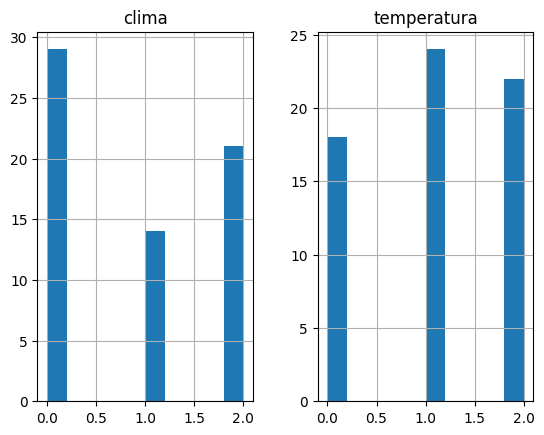

In [8]:
# Se genera el histograma de los datos, pero se excluye la clase (sequia)
data.drop(['sequia'], axis=1).hist() # La columna se elimina de manera temporal, es decir solo la gráfica
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [9]:
# Se verifica que todas las columnas están en el DataFrame
data.head()

,clima,temperatura,sequia
0,2,0,1
1,2,0,1
2,1,0,1
3,0,2,1
6,1,1,1


In [10]:
# Se generan las estadísticas del DataFrame
data.describe()

,clima,temperatura,sequia
count,64.000000,64.000000,64.000000
mean,0.875000,1.062500,0.500000
std,0.881917,0.794325,0.503953
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.500000
75%,2.000000,2.000000,1.000000
max,2.000000,2.000000,1.000000


### Paso 5: Predicción con GBC

In [11]:
# Se deja en X todas las características para el modelo
features = ['clima','temperatura']
X = data[features]
# Se deja en y la clase (no comprar o comprar) porque es lo que queremos predecir
y = data['sequia'].values

# Dividimos el conjunto de datos en entrenamiento (80%) y pruebas (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=6)

# Creamos el modelo, lo ponemos a aprender con fit() y obtenemos predicciones sobre nuestro conjunto de test
# Se instancia el clasificador de ensamble
gbc = GradientBoostingClassifier()
# Se entrena el modelo
gbc.fit(X_train, y_train)
# Se genera lapredicción
prediccion = gbc.predict(X_test)
# Métricas clasificación: Precisión, Recall, F1-Score
print("Precisión: ", round(precision_score(y_test, prediccion, average='weighted'), 2))
print("Recall: ", round(recall_score(y_test, prediccion, average='weighted'),2))
print("F1-Score: ", round(f1_score(y_test, prediccion, average='weighted'),2))

Precisión:  0.76
Recall:  0.77
F1-Score:  0.76


##### Nota: Se puede observar que después de balancear los datos el algoritmo GBC alcanzó 0.76% para la métrica F1 score.

### Paso 6: Aplicar hiperparámetros

Aquí se aplica la técnica de hiperparámetros para mejorar la precision del modelo

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Algoritmo GBC
gbc = GradientBoostingClassifier()

# Hiperparámetros
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
criterion = ['friedman_mse', 'squared_error']
max_depth = [3,5,8]
max_features = ['log2','sqrt']

grid = dict(learning_rate = learning_rate,
            criterion = criterion,
            max_depth = max_depth,
            max_features = max_features)

# Técnica de cuadrícula para hiperparámetros
grid_search = GridSearchCV(estimator = gbc,
                           param_grid = grid,
                           cv= 10,
                           verbose=1,
                           n_jobs=-1,
                           scoring = "accuracy")

searchResults = grid_search.fit(X_train, y_train.ravel())

# Extrae los mejores parámentros para la evaluación del modelo
bestModel = searchResults.best_estimator_

print("Mejores Parámetros (GridSearch):", bestModel)
print("-----------------------------------------------------------")

# Se crea un objeto con los mejores ajustes de Hiperparámetros
gbc = bestModel

# Se entrena el modelo con los mejores parámetros
gbc.fit(X_train, y_train)

# predicción con los mejores parámetros
pred = gbc.predict(X_test)

# Métricas clasificación: Precisión, Recall, F1-Score
print("Precisión: ", round(precision_score(y_test, pred, average='weighted'), 2))
print("Recall: ", round(recall_score(y_test, pred, average='weighted'),2))
print("F1-Score: ", round(f1_score(y_test, pred, average='weighted'),2))

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Mejores Parámetros (GridSearch): GradientBoostingClassifier(learning_rate=0.01, max_features='log2')
-----------------------------------------------------------
Precisión:  0.87
Recall:  0.77
F1-Score:  0.78


##### Nota: La técnica de hiperparámetros permitió que el modelo de predicción GBC mejorara de 0.76% a 0.78% en la métrica F1 score, con los hiperparámetros: learning_rate=0.01, max_features='log2'